# Question 1
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import random

In [37]:
random.seed(10)
np.random.seed(15)

m,s,n = 10, 5, 30
x = stats.norm(m, s).rvs(n)
G = 10000  # Gibbs samples
theta,tau = np.zeros([G]),np.zeros([G])
for g in range(1,G):
    tau[g] = stats.gamma(a = n/2 + 1, scale = 2/((x - theta[g - 1])**2).sum()).rvs()
    theta[g] = stats.norm(x.mean(), scale = 1/(tau[g]*n)**0.5).rvs()


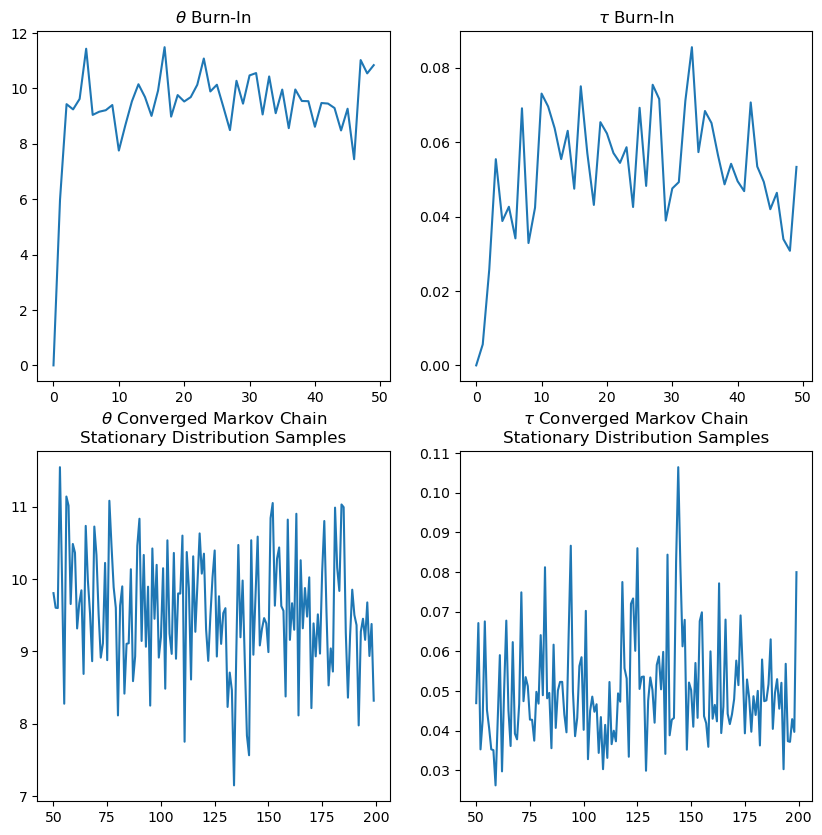

In [38]:
fig,ax = plt.subplots(2, 2, figsize=(10,10))
ax[0,0].set_title("$\\theta$ Burn-In")
ax[0,1].set_title("$\\tau$ Burn-In")
ax[1,0].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples")
ax[1,1].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")
burn = 50
demo = 200
ax[0,0].plot(theta[:burn])
ax[0,1].plot(tau[:burn])
ax[1,0].plot(np.arange(burn, demo, dtype=int), theta[burn:demo])
ax[1,1].plot(np.arange(burn, demo, dtype=int), tau[burn:demo])      

In [39]:
np.quantile(theta[burn:], [0.025, 0.975])

array([ 7.94438278, 11.23191044])

In [40]:
np.quantile(1/(tau[burn:]**0.5), [0.025, 0.975])

array([3.50406945, 5.82343408])

Both our credible intervals contain the values assigned to their respective parameters at the beginning of the simulation.

# Question 2
---
Our data comes from the normal distribution, so assuming $n$ iid observations we have the likelihood

$$P(x | \theta, \tau) = \prod_{i=1}^n\sqrt{\frac{\tau}{2\pi}}\text{exp}\left(-\frac{\tau}{2}(x_i - \theta)^2\right) \propto \tau^{n/2}\text{exp}\left(-\frac{\tau}{2}\sum_{i=1}^n(x_i - \theta)^2\right)$$

We're also given that the priors satisfy

$$\begin{array}{ccc}
P(\theta) \propto \text{exp}\left(-\frac{\tau_0}{2}(\theta - \theta_0)^2\right) & \text{ and } & P(\tau) \propto \tau^{\frac{\alpha}{2} - 1}\text{exp}\left(-\frac{\lambda}{2}\tau\right)
\end{array}$$

We first find $P(\theta|\tau, x)$.

\begin{align*}
P(\theta|\tau, x) &\propto P(x|\tau, \theta)P(\theta) \\
&\propto \text{exp}\left(-\frac{\tau}{2}\sum_{i=1}^n(x_i - \theta)^2\right)\text{exp}\left(-\frac{\tau_0}{2}(\theta - \theta_0)^2\right) \\
&\propto \text{exp}\left(-\frac{\tau}{2}\sum_{i=1}^n(\theta^2 - 2\theta x_i)\right)\text{exp}\left(-\frac{\tau_0}{2}(\theta^2 - 2\theta\theta_0)\right) \\
&= \text{exp}\left(-\frac{\tau}{2}(n\theta^2 - 2\theta n\bar x)\right)\text{exp}\left(-\frac{\tau_0}{2}(\theta^2 - 2\theta\theta_0)\right) \\
&= \text{exp}\left(-\frac{1}{2}(\tau n\theta^2 - 2\tau \theta n\bar x + \tau_0\theta^2 - 2\tau_0\theta\theta_0)\right) \\
&= \text{exp}\left(-\frac{1}{2}((\tau n + \tau_0)\theta^2 - 2\theta(\tau n\bar x + \tau_0\theta_0))\right) \\
&= \text{exp}\left(-\frac{\tau n + \tau_0}{2}\left(\theta^2 - 2\theta\frac{\tau n\bar x + \tau_0\theta_0}{\tau n + \tau_0}\right)\right) \\
\end{align*}

Define $\tilde\theta = \frac{\tau n\bar x + \tau_0\theta_0}{\tau n + \tau_0}$ and $\tilde\tau = \tau n + \tau_0$, then 

\begin{align*}
P(\theta|\tau, x) &\propto \text{exp}\left(-\frac{\tilde\tau}{2}(\theta^2 - 2\theta\tilde\theta)\right) \\
&\propto \text{exp}\left(-\frac{\tilde\tau}{2}(\theta - \tilde\theta)^2\right)
\end{align*}

This is the kernel of the Normal$(\tilde\theta, \tilde\tau)$ distribution, so $\theta|\tau, x \sim \text{N}(\tilde\theta, \tilde\tau)$. We now find $P(\tau|\theta, x)$. 

\begin{align*}
P(\tau|\theta, x) &\propto P(x|\theta, \tau)P(\tau) \\
&\propto \tau^{n/2}\text{exp}\left(-\frac{\tau}{2}\sum_{i=1}^n(x_i - \theta)^2\right)\tau^{\frac{\alpha}{2} - 1}\text{exp}\left(-\frac{\lambda}{2}\tau\right) \\
&= \tau^{\frac{1}{2}(n + \alpha) - 1}\text{exp}\left(-\frac{\tau}{2}\left(\sum_{i=1}^n(x_i - \theta)^2+\lambda\right)\right)
\end{align*}

Define $\tilde\alpha = \frac{1}{2}(n + \alpha)$ and $\tilde\lambda = \frac{1}{2}\left(\sum_{i=1}^n(x_i - \theta)^2+\lambda\right)$, then 

$$P(\tau|\theta, x) \propto \tau^{\tilde\alpha - 1}\text{exp}\left(-\tau\tilde\lambda\right)$$

This is the kernel of the Gamma$(\tilde\alpha, \tilde\lambda)$ distribution, so $\tau|\theta, x \sim \text{Gamma}(\tilde\alpha, \tilde\lambda)$

From the definition of $\tilde\alpha$, we see that the impact of $\alpha$ decreases as sample size increases. Meanwhile, in the definition of $\tilde\lambda$, the impact of $\lambda$ also decreases as sample size increases because each term in the sum is nonnegative. In this sense, $\alpha$ and $\lambda$ are like the "number of datapoints contributed by the prior."

In [55]:
# For convenience, we'll define the normal-gamma procedure as a function.

def gibbs_normal_gamma(x, alpha, lam, theta0, tau0, n_iter=10000):
    """
    Gibbs sampler for a normal(theta, 1/tau) likelihood
    with priors:
      theta ~ Normal(theta0, 1/tau0)
      tau ~ Gamma(alpha, lam)   [shape=alpha, rate=lam]

    Args:
      x       : 1D array of data
      alpha   : prior shape parameter  (alpha>0)
      lam     : prior rate parameter   (lam>0)
      theta0  : prior mean (for theta)
      tau0    : prior precision (for theta)
      n_iter  : total number of Gibbs iterations

    Returns:
      (theta_chain, tau_chain) : arrays of posterior samples
    """
    x = np.asarray(x)
    n = len(x)

    # Storage for samples
    theta_samples = np.zeros(n_iter)
    tau_samples = np.zeros(n_iter)

    # Initialize at reasonable values
    tau_current = np.random.gamma(alpha, 1/lam)  
    theta_current  = np.random.normal(theta0, 1/np.sqrt(tau0))

    for t in range(1,n_iter):
        # ---------------------------
        # 1) Sample theta | tau, x
        # ---------------------------
        # posterior precision and mean
        post_prec = tau_current * n + tau0
        post_mean = (tau_current * n * x.mean() + tau0 * theta0) / post_prec

        # sample from Normal(post_mean, 1/post_prec)
        theta_current = np.random.normal(loc = post_mean, scale = np.sqrt(1/post_prec))

        # ---------------------------
        # 2) Sample tau | theta, x
        # ---------------------------
        # shape = alpha + n/2
        post_shape = (alpha + n)*0.5
        # rate = lam + 0.5 * sum of squared residuals
        sq_resid = np.sum((x - theta_current)**2)
        post_rate = 0.5*(sq_resid + lam)

        # sample from Gamma(post_shape, rate=post_rate)
        tau_current = np.random.gamma(shape=post_shape, scale=1/post_rate)

        # Store draws
        theta_samples[t]  = theta_current
        tau_samples[t] = tau_current

    # Obtain results
    return theta_samples, tau_samples


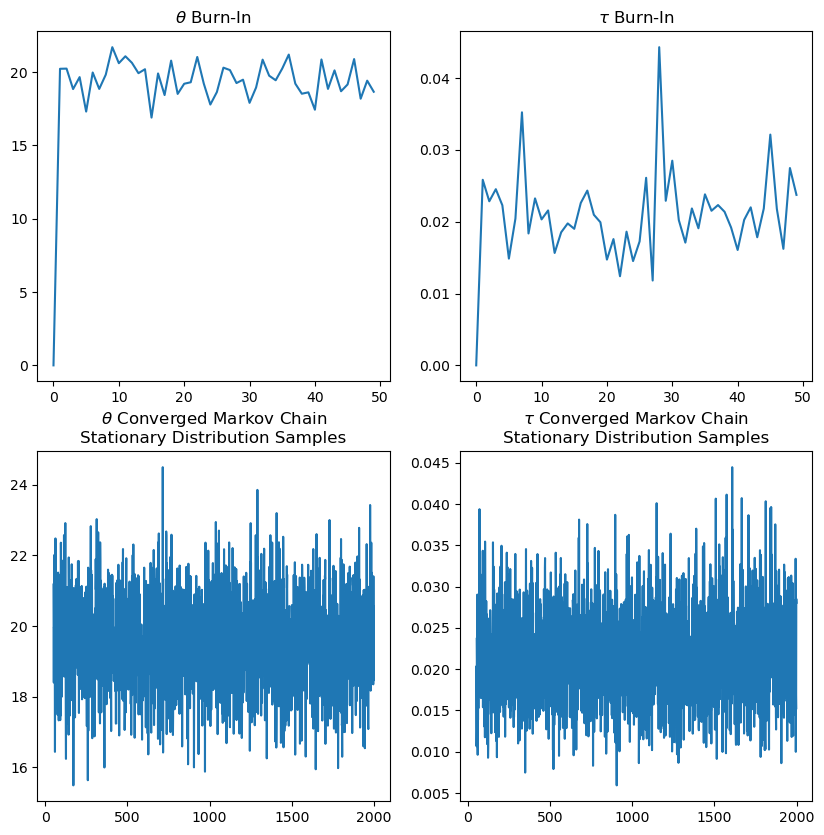

In [85]:
random.seed(20)
np.random.seed(25)

# Obtain Data
data = np.random.normal(20, 5, 30)

# Set prior hyperparameters:
alpha  = 1    # shape of Gamma
lam    = 1    # rate of Gamma
theta0 = 0    # prior mean for theta
tau0   = 0.01   # prior precision for theta (small => vague prior)

# Run Gibbs sampler
theta_chain, tau_chain = gibbs_normal_gamma(data, alpha, lam, theta0, tau0)

fig,ax = plt.subplots(2, 2, figsize=(10,10))
ax[0,0].set_title("$\\theta$ Burn-In")
ax[0,1].set_title("$\\tau$ Burn-In")
ax[1,0].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples")
ax[1,1].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")
burn = 50
demo = 2000
ax[0,0].plot(theta_chain[:burn])
ax[0,1].plot(tau_chain[:burn])
ax[1,0].plot(np.arange(burn, demo, dtype=int), theta_chain[burn:demo])
ax[1,1].plot(np.arange(burn, demo, dtype=int), tau_chain[burn:demo])      


In [86]:
np.quantile(theta_chain[burn:], [0.025, 0.975])

array([17.01502091, 22.04045027])

In [87]:
np.quantile(1/(tau_chain[burn:]**0.5), [0.025, 0.975])

array([5.45087989, 9.1561519 ])

We see that the 95% credible interval for theta contains 50, but the 95% credible interval for standard deviation does not contain 5. This is likely due to the prior of tau pulling the results up.

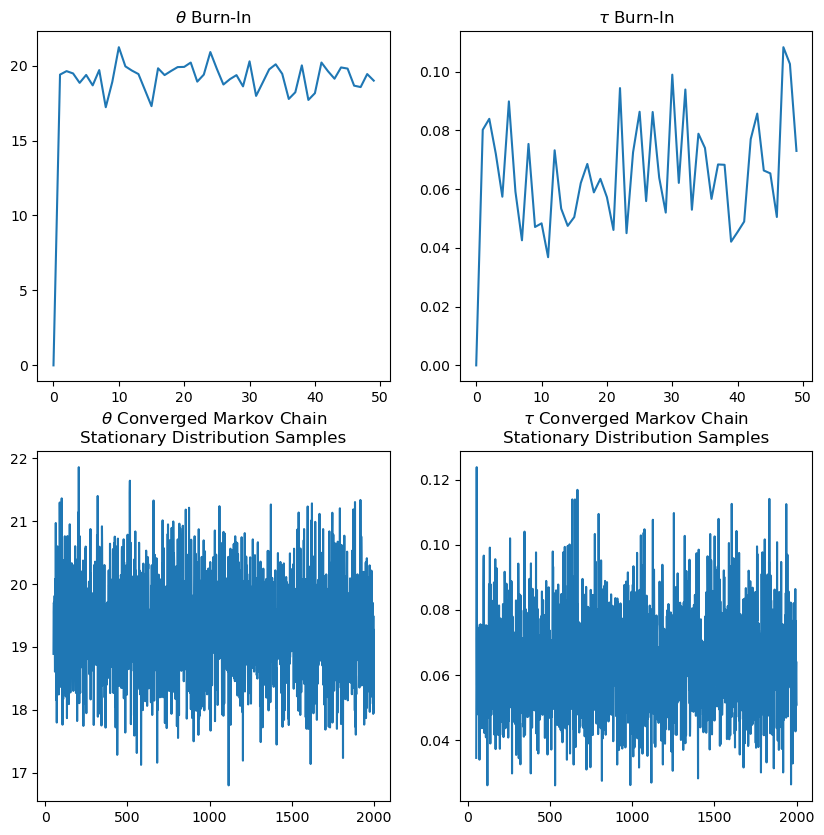

In [91]:
random.seed(30)
np.random.seed(35)

# Obtain Data
data = np.random.normal(20, 5, 30)

# Set prior hyperparameters:
alpha  = 8    # shape of Gamma
lam    = 1    # rate of Gamma
theta0 = 0    # prior mean for theta
tau0   = 0.01   # prior precision for theta (small => vague prior)

# Run Gibbs sampler
theta_chain, tau_chain = gibbs_normal_gamma(data, alpha, lam, theta0, tau0)

fig,ax = plt.subplots(2, 2, figsize=(10,10))
ax[0,0].set_title("$\\theta$ Burn-In")
ax[0,1].set_title("$\\tau$ Burn-In")
ax[1,0].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples")
ax[1,1].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")
burn = 50
demo = 2000
ax[0,0].plot(theta_chain[:burn])
ax[0,1].plot(tau_chain[:burn])
ax[1,0].plot(np.arange(burn, demo, dtype=int), theta_chain[burn:demo])
ax[1,1].plot(np.arange(burn, demo, dtype=int), tau_chain[burn:demo])      


In [89]:
np.quantile(theta_chain[burn:], [0.025, 0.975])

array([17.92331633, 20.75048484])

In [92]:
np.quantile(1/(tau_chain[burn:]**0.5), [0.025, 0.975])

array([3.25207826, 5.16902028])

This time, both 95% credible intervals contain the values of theta and sigma assigned to them prior to the simulation. We can do a more detailed comparison of the effect of prior hyperparameters below:

In [96]:
random.seed(40)
np.random.seed(45)

# Obtain Data
data = np.random.normal(20, 5, 30)
comparison = []

# Set prior hyperparameters:
alpha  = 1    # shape of Gamma
lam    = 1    # rate of Gamma
theta0 = 0    # prior mean for theta
tau0   = 0.01   # prior precision for theta (small => vague prior)

# Run Gibbs sampler
theta_chain, tau_chain = gibbs_normal_gamma(data, alpha, lam, theta0, tau0)
comparison.append({
        "alpha": alpha,
        "lam": lam,
        "theta0": theta0,
        "tau0": tau0,
        "theta left": np.quantile(theta_chain[burn:], [0.025, 0.975])[0],
        "theta right": np.quantile(theta_chain[burn:], [0.025, 0.975])[1],
        "sd left": np.quantile(1/(tau_chain[burn:]**0.5), [0.025, 0.975])[0],
        "sd right": np.quantile(1/(tau_chain[burn:]**0.5), [0.025, 0.975])[1],
    })

# Set prior hyperparameters:
alpha  = 8    # shape of Gamma
lam    = 1    # rate of Gamma
theta0 = 0    # prior mean for theta
tau0   = 0.01   # prior precision for theta (small => vague prior)

# Run Gibbs sampler
theta_chain, tau_chain = gibbs_normal_gamma(data, alpha, lam, theta0, tau0)
comparison.append({
        "alpha": alpha,
        "lam": lam,
        "theta0": theta0,
        "tau0": tau0,
        "theta left": np.quantile(theta_chain[burn:], [0.025, 0.975])[0],
        "theta right": np.quantile(theta_chain[burn:], [0.025, 0.975])[1],
        "sd left": np.quantile(1/(tau_chain[burn:]**0.5), [0.025, 0.975])[0],
        "sd right": np.quantile(1/(tau_chain[burn:]**0.5), [0.025, 0.975])[1],
    })

# Set prior hyperparameters:
alpha  = 1    # shape of Gamma
lam    = 6    # rate of Gamma
theta0 = 0    # prior mean for theta
tau0   = 0.01   # prior precision for theta (small => vague prior)

# Run Gibbs sampler
theta_chain, tau_chain = gibbs_normal_gamma(data, alpha, lam, theta0, tau0)
comparison.append({
        "alpha": alpha,
        "lam": lam,
        "theta0": theta0,
        "tau0": tau0,
        "theta left": np.quantile(theta_chain[burn:], [0.025, 0.975])[0],
        "theta right": np.quantile(theta_chain[burn:], [0.025, 0.975])[1],
        "sd left": np.quantile(1/(tau_chain[burn:]**0.5), [0.025, 0.975])[0],
        "sd right": np.quantile(1/(tau_chain[burn:]**0.5), [0.025, 0.975])[1],
    })

# Set prior hyperparameters:
alpha  = 1    # shape of Gamma
lam    = 1    # rate of Gamma
theta0 = 40    # prior mean for theta
tau0   = 0.01   # prior precision for theta (small => vague prior)

# Run Gibbs sampler
theta_chain, tau_chain = gibbs_normal_gamma(data, alpha, lam, theta0, tau0)
comparison.append({
        "alpha": alpha,
        "lam": lam,
        "theta0": theta0,
        "tau0": tau0,
        "theta left": np.quantile(theta_chain[burn:], [0.025, 0.975])[0],
        "theta right": np.quantile(theta_chain[burn:], [0.025, 0.975])[1],
        "sd left": np.quantile(1/(tau_chain[burn:]**0.5), [0.025, 0.975])[0],
        "sd right": np.quantile(1/(tau_chain[burn:]**0.5), [0.025, 0.975])[1],
    })

# Set prior hyperparameters:
alpha  = 1    # shape of Gamma
lam    = 1    # rate of Gamma
theta0 = 0    # prior mean for theta
tau0   = 5   # prior precision for theta (small => vague prior)

# Run Gibbs sampler
theta_chain, tau_chain = gibbs_normal_gamma(data, alpha, lam, theta0, tau0)
comparison.append({
        "alpha": alpha,
        "lam": lam,
        "theta0": theta0,
        "tau0": tau0,
        "theta left": np.quantile(theta_chain[burn:], [0.025, 0.975])[0],
        "theta right": np.quantile(theta_chain[burn:], [0.025, 0.975])[1],
        "sd left": np.quantile(1/(tau_chain[burn:]**0.5), [0.025, 0.975])[0],
        "sd right": np.quantile(1/(tau_chain[burn:]**0.5), [0.025, 0.975])[1],
    })

# Set prior hyperparameters:
alpha  = 8    # shape of Gamma
lam    = 6    # rate of Gamma
theta0 = 40    # prior mean for theta
tau0   = 5   # prior precision for theta (small => vague prior)

# Run Gibbs sampler
theta_chain, tau_chain = gibbs_normal_gamma(data, alpha, lam, theta0, tau0)
comparison.append({
        "alpha": alpha,
        "lam": lam,
        "theta0": theta0,
        "tau0": tau0,
        "theta left": np.quantile(theta_chain[burn:], [0.025, 0.975])[0],
        "theta right": np.quantile(theta_chain[burn:], [0.025, 0.975])[1],
        "sd left": np.quantile(1/(tau_chain[burn:]**0.5), [0.025, 0.975])[0],
        "sd right": np.quantile(1/(tau_chain[burn:]**0.5), [0.025, 0.975])[1],
    })

In [97]:
import pandas as pd

df_comparison = pd.DataFrame(comparison)
print(df_comparison)

   alpha  lam  theta0  tau0  theta left  theta right    sd left   sd right
0      1    1       0  0.01   16.140591    20.005863   4.208690   7.032181
1      8    1       0  0.01   16.427648    19.935524   3.856361   6.133501
2      1    6       0  0.01   16.174332    20.023247   4.223596   7.052879
3      1    1      40  0.01   16.556097    20.445562   4.190383   7.006282
4      1    1       0  5.00   -0.569718     1.197354  14.746852  24.576604
5      8    6      40  5.00   38.788151    40.525815  15.912543  25.092069


A major thing to note is that when tau0 is large, the credible intervals are very far from where they're supposed to be. This shows that the values of the prior hyperparameters matter for statistical analyses.

# Question 3
---
We derive a similar result for the multinomial-Dirichlet. Let $\theta$ be a vector of $k$ probabilities that we wish to infer, and let $x$ be the vector of counts in each of the $k$ categories, with total count $n$. Let $\alpha$ be the vector that parametrizes the Dirichlet distribution. 

The multinomial distribution likelihood is

$$P(x|\theta) = n!\prod_{i=1}^k\frac{\theta_i^{x_i}}{x_i!}$$

The dirichlet prior is

$$P(\theta|\alpha) = \Gamma\left(\sum_{i=1}^k\alpha_i\right)\prod_{i=1}^k\frac{\theta_i^{\alpha_i - 1}}{\Gamma(\alpha_i)}$$

Applying Bayes' Theorem gives

\begin{align*}
P(\theta|x,\alpha) &= \frac{P(x|\theta)P(\theta|\alpha)}{P(x)} \\
&= \frac{P(x|\theta)P(\theta|\alpha)}{\int P(x|\theta)P(\theta|\alpha) d\theta} \\
&= \frac{n!\prod_{i=1}^k\frac{\theta_i^{x_i}}{x_i!}\Gamma\left(\sum_{i=1}^k\alpha_i\right)\prod_{i=1}^k\frac{\theta_i^{\alpha_i - 1}}{\Gamma(\alpha_i)}}{\int_0^1\cdots\int_0^1 n!\prod_{i=1}^k\frac{\theta_i^{x_i}}{x_i!}\Gamma\left(\sum_{i=1}^k\alpha_i\right)\prod_{i=1}^k\frac{\theta_i^{\alpha_i - 1}}{\Gamma(\alpha_i)} d\theta_1\cdots d\theta_k} \\
&= \frac{\Gamma\left(\sum_{i=1}^k\alpha_i\right)n!\prod_{i=1}^k\frac{\theta_i^{\alpha_i + x_i - 1}}{x_i!\Gamma(\alpha_i)}}{ \Gamma\left(\sum_{i=1}^k\alpha_i\right)n!\int_0^1\cdots\int_0^1\prod_{i=1}^k\frac{\theta_i^{\alpha_i + x_i - 1}}{x_i!\Gamma(\alpha_i)} d\theta_1\cdots d\theta_k} \\
&= \frac{\prod_{i=1}^k\theta_i^{\alpha_i + x_i - 1}}{\int_0^1\cdots\int_0^1\prod_{i=1}^k\theta_i^{\alpha_i + x_i - 1} d\theta_1\cdots d\theta_k} \\
&= \frac{\prod_{i=1}^k\theta_i^{\alpha_i + x_i - 1}}{\frac{\prod_{i=1}^k\Gamma(\alpha_i + x_i)}{\Gamma\left(\sum_{i=1}^k(\alpha_i + x_i)\right)}\int_0^1\cdots\int_0^1\frac{\Gamma\left(\sum_{i=1}^k(\alpha_i + x_i)\right)}{\prod_{i=1}^k\Gamma(\alpha_i + x_i)}\prod_{i=1}^k\theta_i^{\alpha_i + x_i - 1} d\theta_1\cdots d\theta_k} \\
&= \frac{\prod_{i=1}^k\theta_i^{\alpha_i + x_i - 1}}{\frac{\prod_{i=1}^k\Gamma(\alpha_i + x_i)}{\Gamma\left(\sum_{i=1}^k(\alpha_i + x_i)\right)}} \\
&= \Gamma\left(\sum_{i=1}^k(\alpha_i + x_i)\right)\prod_{i=1}^k\frac{\theta_i^{\alpha_i + x_i - 1}}{\Gamma(\alpha_i + x_i)}
\end{align*}

The second-last equality is true because the integral is that of the Dirichlet$(\alpha + x)$ distirbution over the support of that distribution. We conclude that our posterior is that of the Dirichlet$(\alpha + x)$ distribution.